In [3]:
import sys
import os

# Add the project root directory to sys.path
project_root = os.path.abspath("..")  # Adjust this path if your notebook is in a different location
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

import src.data_preprocessing as prp
import src.feature_engineering as ftr
from sklearn.decomposition import PCA

# Reload the module to reflect the changes
importlib.reload(prp)
importlib.reload(ftr)

<module 'src.feature_engineering' from 'd:\\work\\projects\\U of T\\CSC311\\final_project\\Credit-Risk-Prediction\\src\\feature_engineering.py'>

In [5]:
# Load the dataset

accepted_data, rejected_data = prp.load_data(processed=True)

Since our data contains a lot of missing values. We need to impute some values into these.

In [6]:
accepted_data, rejected_data = prp.impute_data(accepted_data, rejected_data)

We need to transform the debt to income / dti columns to a consistent format and we choose to normalize them. 

In [7]:
rejected_data.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


In [8]:
accepted_data["dti"] = accepted_data["dti"] / 100
rejected_data["Debt-To-Income Ratio"] = rejected_data["Debt-To-Income Ratio"].str.rstrip("%").astype("float") / 100

In [9]:
accepted_data.shape, rejected_data.shape

((1980000, 25), (27648741, 9))

In [10]:
rejected_data.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,0.1000,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,0.1000,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,0.1000,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,0.3864,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,0.0943,209xx,MD,< 1 year,0.0


Since we only care about specific columns in rejected_data (i.e. those which are in accepted_data and also relevant to our analysis), we subset the data on these columns.<br>

Columns:
- Amount Requested (loan_amnt in accepted_data)
- Debt-To-Income Ratio (dti in accepted data)
- State (addr_state in accepted data)
- Employment Length (emp_length in accepted_data)

In [11]:
accepted_data_subset = accepted_data[["loan_amnt", "dti", "addr_state", "emp_length"]]

accepted_data_subset.columns = ["Amount Requested", "Debt-To-Income Ratio", "State", "Employment Length"]

In [12]:
accepted_data_subset.head()

,Amount Requested,Debt-To-Income Ratio,State,Employment Length
0,3600.0,0.0591,PA,10+ years
1,24700.0,0.1606,SD,10+ years
2,20000.0,0.1078,IL,10+ years
3,35000.0,0.1706,NJ,10+ years
4,10400.0,0.2537,PA,3 years


In [13]:
rejected_data_subset = rejected_data[["Amount Requested", "Debt-To-Income Ratio", "State", "Employment Length"]]

In [14]:
rejected_data_subset.head()

,Amount Requested,Debt-To-Income Ratio,State,Employment Length
0,1000.0,0.1000,NM,4 years
1,1000.0,0.1000,MA,< 1 year
2,11000.0,0.1000,MD,1 year
3,6000.0,0.3864,MA,< 1 year
4,1500.0,0.0943,MD,< 1 year


In [15]:
# Combine the data for training the isolation forest
combined_data = pd.concat([accepted_data_subset, rejected_data_subset], axis=0)

In [16]:
combined_data.head()

,Amount Requested,Debt-To-Income Ratio,State,Employment Length
0,3600.0,0.0591,PA,10+ years
1,24700.0,0.1606,SD,10+ years
2,20000.0,0.1078,IL,10+ years
3,35000.0,0.1706,NJ,10+ years
4,10400.0,0.2537,PA,3 years


In [17]:
# Finding categorical columns
combined_data.select_dtypes(include=["object"]).columns

Index(['State', 'Employment Length'], dtype='object')

In [18]:
rejected_data.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,0.1000,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,0.1000,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,0.1000,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,0.3864,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,0.0943,209xx,MD,< 1 year,0.0


In [19]:
# Convert categorical variables to numerical
# sparse = True is used to save memory
categorical_columns = ["State", "Employment Length"]

combined_data_numerical = pd.get_dummies(
    combined_data, 
    columns=categorical_columns, 
    drop_first=True, 
    sparse=True
)


In [20]:
accepted_data_numerical = combined_data_numerical.iloc[:accepted_data.shape[0], :]

In [21]:
combined_data_numerical.head()

,Amount Requested,Debt-To-Income Ratio,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,...,Employment Length_10+ years,Employment Length_2 years,Employment Length_3 years,Employment Length_4 years,Employment Length_5 years,Employment Length_6 years,Employment Length_7 years,Employment Length_8 years,Employment Length_9 years,Employment Length_< 1 year
0,3600.0,0.0591,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,24700.0,0.1606,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,20000.0,0.1078,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,35000.0,0.1706,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,10400.0,0.2537,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [22]:
accepted_data_numerical.head()

,Amount Requested,Debt-To-Income Ratio,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,...,Employment Length_10+ years,Employment Length_2 years,Employment Length_3 years,Employment Length_4 years,Employment Length_5 years,Employment Length_6 years,Employment Length_7 years,Employment Length_8 years,Employment Length_9 years,Employment Length_< 1 year
0,3600.0,0.0591,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,24700.0,0.1606,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,20000.0,0.1078,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,35000.0,0.1706,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,10400.0,0.2537,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [23]:
rejected_data.isna().sum()

Amount Requested        0
Application Date        0
Loan Title              0
Risk_Score              0
Debt-To-Income Ratio    0
Zip Code                0
State                   0
Employment Length       0
Policy Code             0
dtype: int64

In [24]:
accepted_data.isna().sum()

loan_amnt               0
term                    0
int_rate                0
grade                   0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
url                     0
purpose                 0
addr_state              0
dti                     0
earliest_cr_line        0
fico_range_high         0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mo_sin_old_il_acct      0
mo_sin_old_rev_tl_op    0
mort_acc                0
dtype: int64

In [25]:
na_counts = combined_data.isna().sum()
print(na_counts)

Amount Requested        0
Debt-To-Income Ratio    0
State                   0
Employment Length       0
dtype: int64


In [26]:
# Sample a smaller subset of the data for training the isolation forest
sampled_data = combined_data_numerical.sample(frac=0.1, random_state=42)

# Train the isolation forest
isolation_forest = ftr.create_isolation_forest(sampled_data)

c:\Users\ACER\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [27]:
sampled_accepted_data = accepted_data_numerical.sample(frac=0.1, random_state=42)

isolation_forest_2 = ftr.create_isolation_forest(sampled_accepted_data)

c:\Users\ACER\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [28]:
accepted_data_subset.head()

,Amount Requested,Debt-To-Income Ratio,State,Employment Length
0,3600.0,0.0591,PA,10+ years
1,24700.0,0.1606,SD,10+ years
2,20000.0,0.1078,IL,10+ years
3,35000.0,0.1706,NJ,10+ years
4,10400.0,0.2537,PA,3 years


In [29]:
# Calculate anomaly scores for accepted data
accepted_data_subset['anomaly_score'] = isolation_forest_2.decision_function(accepted_data_numerical)

c:\Users\ACER\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\ACER\AppData\Local\Temp\ipykernel_4604\1073543833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accepted_data_subset['anomaly_score'] = isolation_forest_2.decision_function(accepted_data_numerical)


In [30]:
rejected_data_numerical = combined_data_numerical.iloc[accepted_data.shape[0]:, :]

Since there are too many rows in rejected data, we need to split it into batches in order to compute the anomaly score for each row.

In [ ]:
# Define batch size
batch_size = 100000  # Adjust based on available memory

# Placeholder for results
anomaly_scores = []

# Split data into batches
num_rows = rejected_data_numerical.shape[0]
for start in range(0, num_rows, batch_size):
    end = start + batch_size
    batch = rejected_data_numerical[start:end]
    print(f"Processing rows {start} to {end}")
    # Compute anomaly scores for the batch
    batch_scores = isolation_forest_2.decision_function(batch)
    anomaly_scores.extend(batch_scores)

# Convert the results back to a numpy array or DataFrame
anomaly_scores = np.array(anomaly_scores)

In [34]:
rejected_data_subset['anomaly_score'] = anomaly_scores

C:\Users\ACER\AppData\Local\Temp\ipykernel_4604\2061186685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejected_data_subset['anomaly_score'] = anomaly_scores


In [35]:
rejected_data_subset

,Amount Requested,Debt-To-Income Ratio,State,Employment Length,anomaly_score
0,1000.0,0.1000,NM,4 years,0.125045
1,1000.0,0.1000,MA,< 1 year,0.128318
2,11000.0,0.1000,MD,1 year,0.181164
3,6000.0,0.3864,MA,< 1 year,0.121312
4,1500.0,0.0943,MD,< 1 year,0.157348
...,...,...,...,...,...
27648736,10000.0,0.4126,OH,< 1 year,0.141771
27648737,10000.0,0.0148,MD,5 years,0.151157
27648738,1200.0,0.1026,CA,< 1 year,0.144459
27648739,25000.0,0.1771,NM,< 1 year,0.138818


In [36]:
accepted_data_subset

,Amount Requested,Debt-To-Income Ratio,State,Employment Length,anomaly_score
0,3600.0,0.0591,PA,10+ years,0.149696
1,24700.0,0.1606,SD,10+ years,0.169970
2,20000.0,0.1078,IL,10+ years,0.165103
3,35000.0,0.1706,NJ,10+ years,0.142009
4,10400.0,0.2537,PA,3 years,0.138657
...,...,...,...,...,...
1979995,14300.0,0.1874,NY,5 years,0.149792
1979996,8400.0,0.1794,FL,3 years,0.162692
1979997,21575.0,0.2854,TN,10+ years,0.152652
1979998,3000.0,0.1428,NY,9 years,0.134415


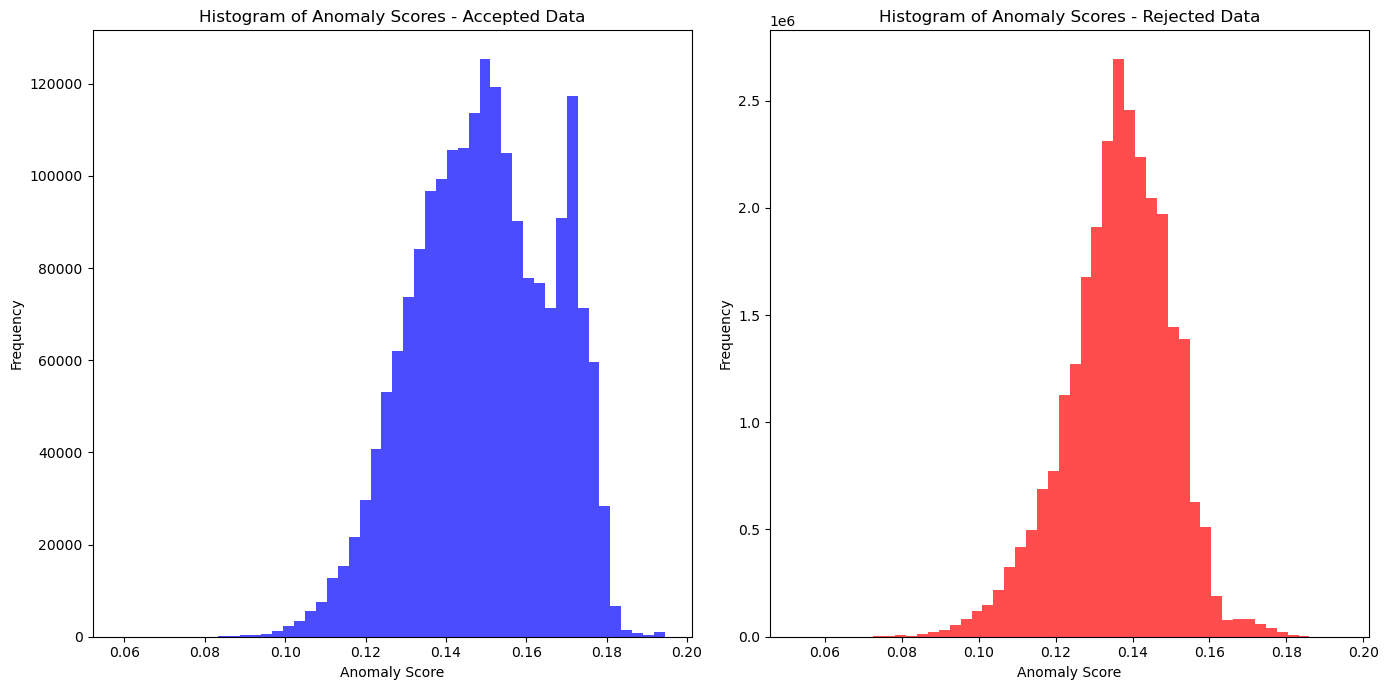

In [37]:
plt.figure(figsize=(14, 7))

# Plot histogram for accepted data
plt.subplot(1, 2, 1)
plt.hist(accepted_data_subset['anomaly_score'], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Anomaly Scores - Accepted Data')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

# Plot histogram for rejected data
plt.subplot(1, 2, 2)
plt.hist(rejected_data_subset['anomaly_score'], bins=50, color='red', alpha=0.7)
plt.title('Histogram of Anomaly Scores - Rejected Data')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [40]:
accepted_data_subset['anomaly_score'].describe()

count    1.980000e+06
mean     1.493333e-01
std      1.704059e-02
min      5.882966e-02
25%      1.370085e-01
50%      1.495745e-01
75%      1.630087e-01
max      1.944671e-01
Name: anomaly_score, dtype: float64

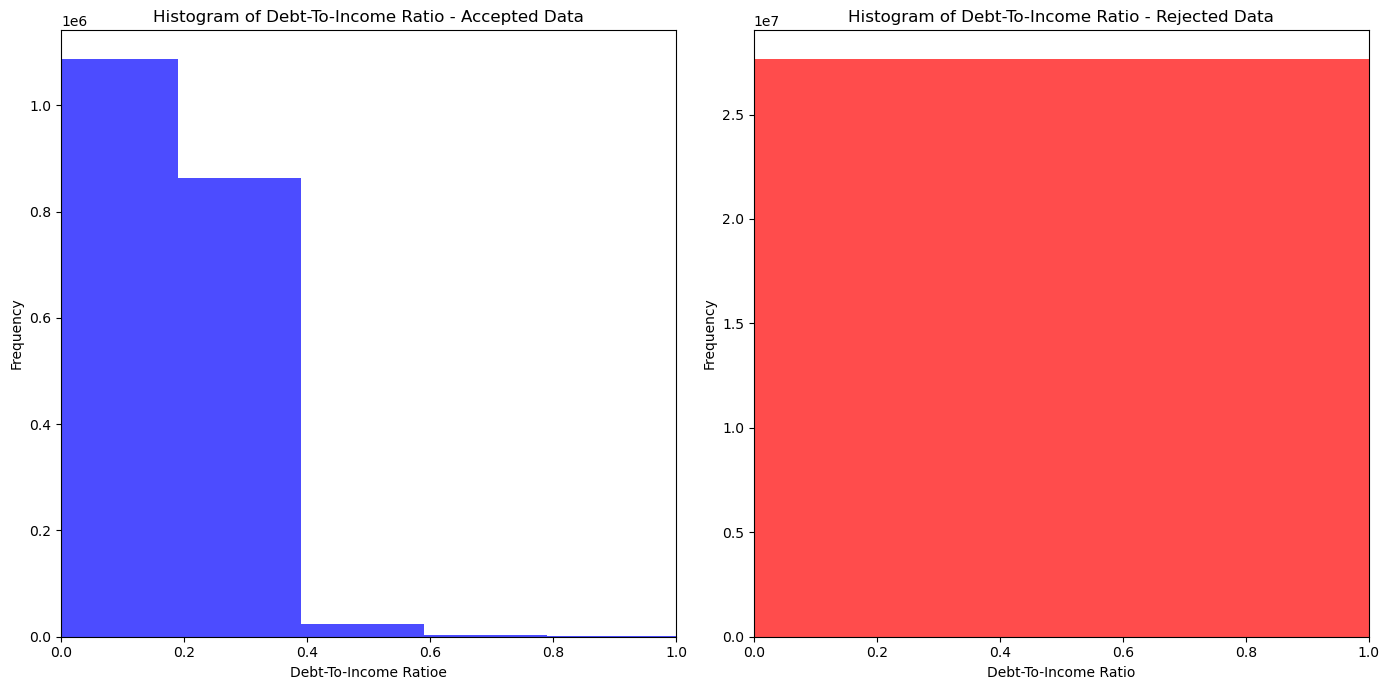

In [42]:
plt.figure(figsize=(14, 7))

min_limit = 0
max_limit = 1

# Plot histogram for accepted data
plt.subplot(1, 2, 1)
plt.hist(accepted_data_subset["Debt-To-Income Ratio"], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Debt-To-Income Ratio - Accepted Data')
plt.xlabel('Debt-To-Income Ratioe')
plt.ylabel('Frequency')
plt.xlim([min_limit, max_limit])

# Plot histogram for rejected data
plt.subplot(1, 2, 2)
plt.hist(rejected_data_subset['Debt-To-Income Ratio'], bins=10, color='red', alpha=0.7)
plt.title('Histogram of Debt-To-Income Ratio - Rejected Data')
plt.xlabel('Debt-To-Income Ratio')
plt.ylabel('Frequency')
plt.xlim([min_limit, max_limit])

plt.tight_layout()
plt.show()

C:\Users\ACER\AppData\Local\Temp\ipykernel_4604\2348641049.py:19: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()


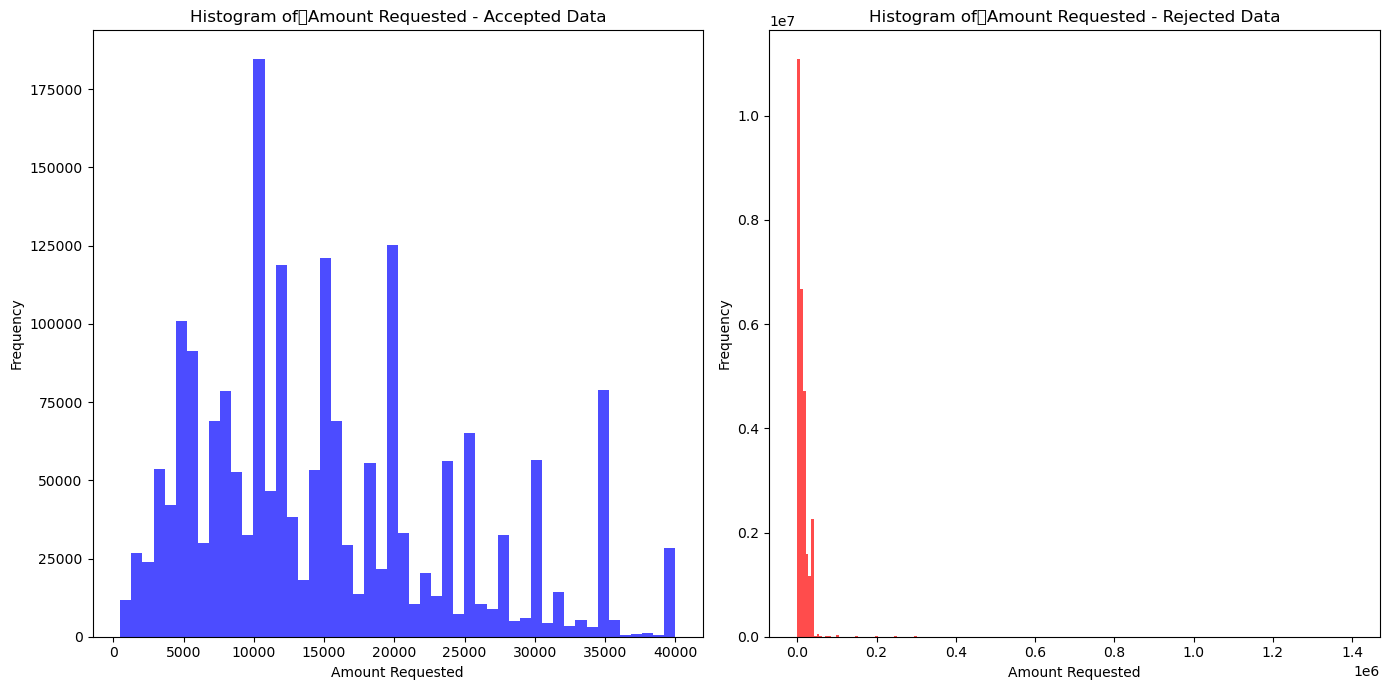

In [ ]:
plt.figure(figsize=(14, 7))

# Plot histogram for accepted data
plt.subplot(1, 2, 1)
plt.hist(accepted_data_subset["Amount Requested"], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of	Amount Requested - Accepted Data')
plt.xlabel('Amount Requested')
plt.ylabel('Frequency')

# Plot histogram for rejected data
plt.subplot(1, 2, 2)
plt.hist(rejected_data_subset['Amount Requested'], bins=200, color='red', alpha=0.7)
plt.title('Histogram of	Amount Requested - Rejected Data')
plt.xlabel('Amount Requested')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [52]:
accepted_data_subset.head()

,Amount Requested,Debt-To-Income Ratio,State,Employment Length,anomaly_score
0,3600.0,0.0591,PA,10+ years,0.149696
1,24700.0,0.1606,SD,10+ years,0.169970
2,20000.0,0.1078,IL,10+ years,0.165103
3,35000.0,0.1706,NJ,10+ years,0.142009
4,10400.0,0.2537,PA,3 years,0.138657


In [53]:
rejected_data_subset.head()

,Amount Requested,Debt-To-Income Ratio,State,Employment Length,anomaly_score
0,1000.0,0.1000,NM,4 years,0.125045
1,1000.0,0.1000,MA,< 1 year,0.128318
2,11000.0,0.1000,MD,1 year,0.181164
3,6000.0,0.3864,MA,< 1 year,0.121312
4,1500.0,0.0943,MD,< 1 year,0.157348


In [54]:
rejected_data.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,0.1000,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,0.1000,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,0.1000,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,0.3864,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,0.0943,209xx,MD,< 1 year,0.0


In [55]:
accepted_data.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,...,fico_range_high,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc
0,3600.0,36 months,13.99,C,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,...,679.0,0.0,2765.0,29.7,13.0,w,Individual,148.0,128.0,1.0
1,24700.0,36 months,11.99,C,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,...,719.0,0.0,21470.0,19.2,38.0,w,Individual,113.0,192.0,4.0
2,20000.0,60 months,10.78,B,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,...,699.0,0.0,7869.0,56.2,18.0,w,Joint App,125.0,184.0,5.0
3,35000.0,60 months,14.85,C,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,...,789.0,0.0,7802.0,11.6,17.0,w,Individual,36.0,87.0,1.0
4,10400.0,60 months,22.45,F,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,...,699.0,0.0,21929.0,64.5,35.0,w,Individual,128.0,210.0,6.0


In [56]:
accepted_data.isna().sum()

loan_amnt               0
term                    0
int_rate                0
grade                   0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
url                     0
purpose                 0
addr_state              0
dti                     0
earliest_cr_line        0
fico_range_high         0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mo_sin_old_il_acct      0
mo_sin_old_rev_tl_op    0
mort_acc                0
dtype: int64

In [58]:
# Save the DataFrame to a CSV file
accepted_data.to_csv('../data/finalized/accepted_data_finalized.csv', index=False)